In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
import time
import pickle

In [288]:
data = pd.read_csv('loan.csv')

In [289]:
for col in data.columns:
    print(col)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
b

## Preprocessing

In [290]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
            "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 1
    else:
        return 0
    
    
y = data['loan_status'].apply(loan_condition)
y.name = 'bad_loan'

In [291]:
def term_str_to_int(term_str):
    return [int(s) for s in term_str.split() if s.isdigit()][0]
data['term'] = data['term'].apply(term_str_to_int)

In [292]:
def grade_str_to_int(grade_str):
    return ord(grade_str.lower()) - 97
data['grade'] = data['grade'].apply(grade_str_to_int)

In [293]:
def subgrade_str_to_int(subgrade_str):
    return grade_str_to_int(subgrade_str[0]) * 5 + (int(subgrade_str[1])-1)
data['sub_grade'] = data['sub_grade'].apply(subgrade_str_to_int)

In [294]:
def emplength_str_to_int(emplength_str):
    if pd.isnull(emplength_str):
        return np.nan
    else:
        return int(re.sub('[^0-9]+', '', str(emplength_str)))
data['emp_length'] = data['emp_length'].apply(emplength_str_to_int)

In [295]:
def pymntplan_str_to_int(pymntplan_str):
    if pymntplan_str == 'y':
        return 1
    else:
        return 0
data['pymnt_plan'] = data['pymnt_plan'].apply(pymntplan_str_to_int)

In [296]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%Y')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%Y')
data['sec_app_earliest_cr_line'] = pd.to_datetime(data['sec_app_earliest_cr_line'], 
                                                  format='%b-%Y')
def month_diff(a, b):
    return 12 * (a.dt.year - b.dt.year) + (a.dt.month - b.dt.month)

data['earliest_cr_line'] = month_diff(data['issue_d'], data['earliest_cr_line'])
data['sec_app_earliest_cr_line'] = month_diff(data['issue_d'], 
                                              data['sec_app_earliest_cr_line'])

In [297]:
def applicationtype_str_to_int(applicationtype_str):
    if applicationtype_str == 'Joint App':
        return 1
    else:
        return 0
data['application_type_joint'] = data['application_type'].apply(applicationtype_str_to_int)

In [298]:
def disbursement_str_to_int(disbursement_str):
    if disbursement_str == 'Cash':
        return 1
    else:
        return 0
data['disbursement_method_cash'] = data['disbursement_method'].apply(disbursement_str_to_int)

In [300]:
to_dummies = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 
              'verification_status_joint']
data = pd.get_dummies(data, prefix=to_dummies, columns=to_dummies)

In [333]:
fill_na_100 = ['dti', 'pct_tl_nvr_dlq']
data[fill_na_100] = data[fill_na_100].fillna(100)

data.fillna(0, inplace=True)

In [336]:
data.to_pickle('data.pkl.gzip')

In [337]:
y.to_pickle('y.pkl.gzip')

## Feature selection and transformation

In [157]:
data = pd.read_pickle('data.pkl.gzip')
y = pd.read_pickle('y.pkl.gzip')

In [158]:
data = data.loc[:,~data.columns.str.startswith('addr_state')]

In [120]:
pos_samples = y[y == 1].sample(frac=0.5, axis=0).index
neg_samples = y[y == 0].sample(len(pos_samples), axis=0).index
samples = pos_samples.union(neg_samples)
len(samples)

297032

In [181]:
pos_samples_out = y[~y.index.isin(samples)][y == 1].index
neg_samples_out = y[~y.index.isin(samples)][y == 0].sample(len(pos_samples_out), axis=0).index
samples_out = pos_samples_out.union(neg_samples_out)
len(samples_out)

297034

In [121]:
columns_of_interest = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 
                       'home_ownership_RENT', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 
                       'home_ownership_ANY', 'home_ownership_NONE', 'home_ownership_OWN', 'annual_inc', 
                       'purpose_credit_card', 'purpose_debt_consolidation', 
                       'purpose_small_business', 'purpose_home_improvement', 'purpose_car', 'purpose_moving',
                       'purpose_major_purchase', 'purpose_vacation', 'purpose_other', 'purpose_renewable_energy',
                       'purpose_medical', 'purpose_house', 'purpose_wedding', 'dti', 'total_acc', 
                       'verification_status_Not Verified', 'verification_status_Verified', 
                       'verification_status_Source Verified']
len(columns_of_interest)

32

In [57]:
corrs = pd.Series(index=data.columns)

for col in data.columns:
    corrs[col] = y[samples].corr(data.loc[samples, col])
    
corrs = corrs.reindex(corrs.abs().sort_values(ascending=False).index)

In [53]:
for key, value in corrs[~corrs.index.isin(columns_of_interest)].items():
    print(f'{key}: {value}')

total_rec_prncp: -0.3739185040711337
last_pymnt_amnt: -0.3471889010465312
out_prncp: -0.2720395736253464
out_prncp_inv: -0.27201441272081706
total_pymnt_inv: -0.2224464964660357
total_pymnt: -0.22234166063768032
total_rec_late_fee: 0.1438304675261651
bc_open_to_buy: -0.13132456777570267
verification_status_Not Verified: -0.1308368218796304
acc_open_past_24mths: 0.12607590605424995
max_bal_bc: -0.11705354211515404
total_bc_limit: -0.116348204091602
inq_last_6mths: 0.11633934093267301
num_tl_op_past_12m: 0.11222684219013611
verification_status_Verified: 0.10683787586074785
disbursement_method_cash: 0.10432689390218106
percent_bc_gt_75: 0.10218370734423633
tot_hi_cred_lim: -0.09636471369470265
revol_util: 0.09423809054029013
total_rev_hi_lim: -0.0925581847236627
bc_util: 0.09254791975909404
avg_cur_bal: -0.08990460964401595
all_util: -0.08843458744098102
total_rec_int: 0.08229247800975534
tot_cur_bal: -0.08143743331678943
il_util: -0.07849224291953634
open_act_il: -0.06974420098607155
sec

In [58]:
for key, value in corrs[corrs.index.isin(columns_of_interest)].items():
    print(f'{key}: {value}')

sub_grade: 0.32772924804591475
grade: 0.3204979547664808
int_rate: 0.297360183004322
term: 0.13246696045900264
verification_status_Not Verified: -0.1308368218796304
verification_status_Verified: 0.10683787586074785
home_ownership_MORTGAGE: -0.07195431014947318
home_ownership_RENT: 0.07135981615144868
purpose_credit_card: -0.0590682026176772
installment: 0.05359837610335523
dti: 0.05341012549077898
purpose_debt_consolidation: 0.05172101570177041
annual_inc: -0.05140058683962021
loan_amnt: 0.04664738248862022
purpose_small_business: 0.030496705476831535
emp_length: -0.022003362069821057
total_acc: 0.021894209805058438
verification_status_Source Verified: 0.019193216066348936
purpose_home_improvement: -0.016092645413213605
purpose_car: -0.01384804596100944
purpose_moving: 0.008726838155282707
purpose_major_purchase: -0.004731987515563622
home_ownership_OTHER: 0.0044295941332283964
purpose_vacation: -0.0037521409650247686
home_ownership_ANY: -0.003402781838578363
home_ownership_NONE: -0.00

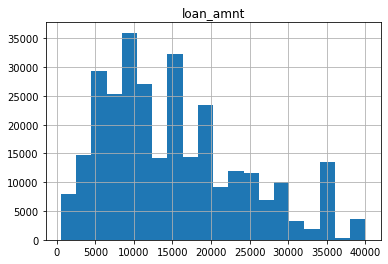

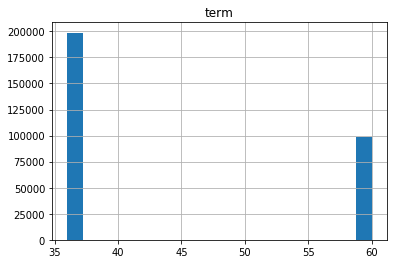

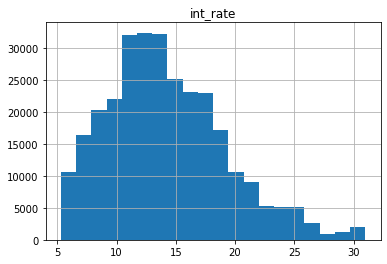

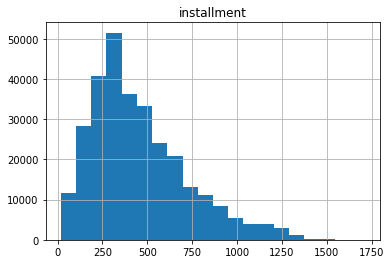

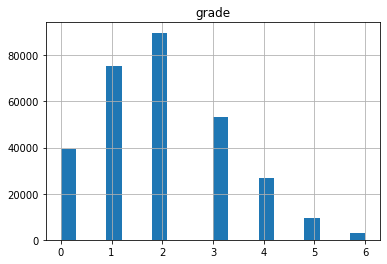

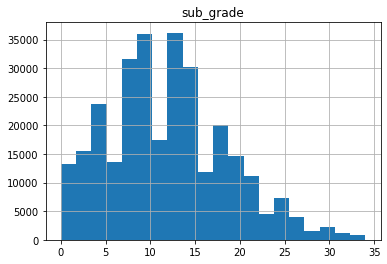

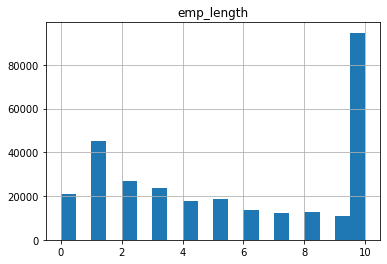

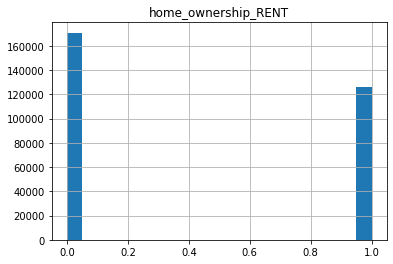

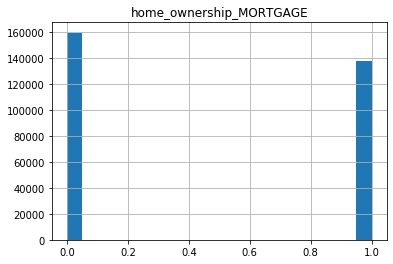

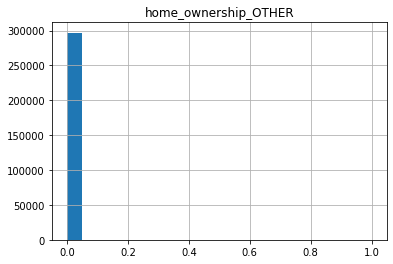

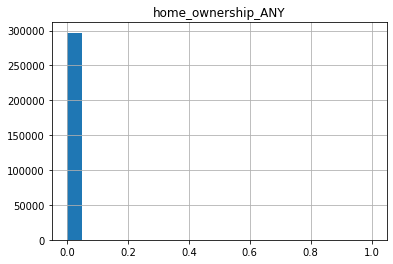

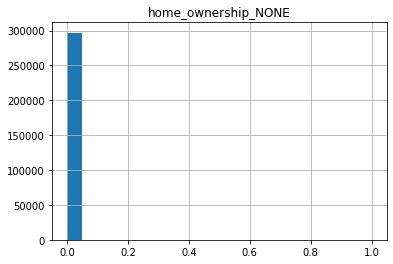

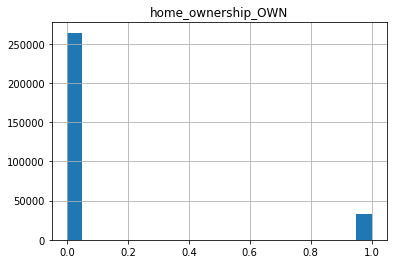

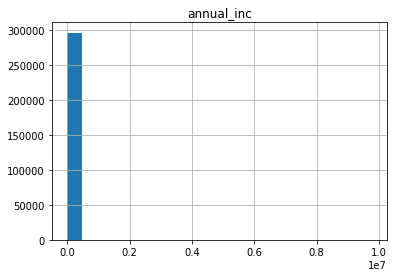

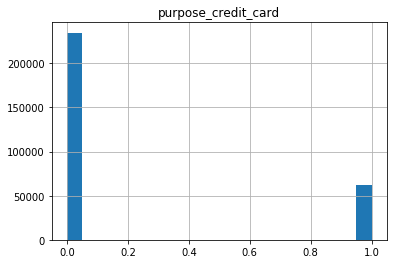

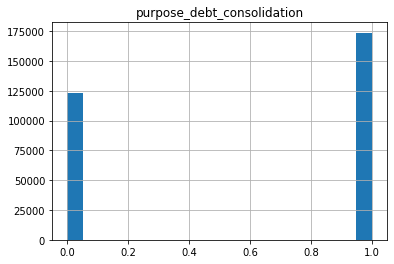

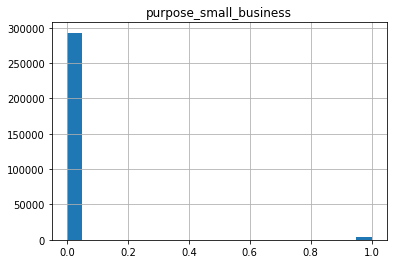

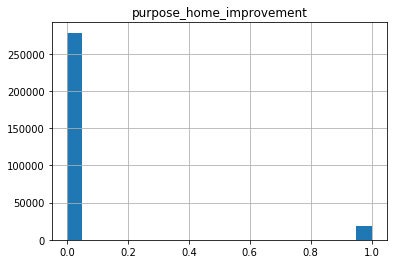

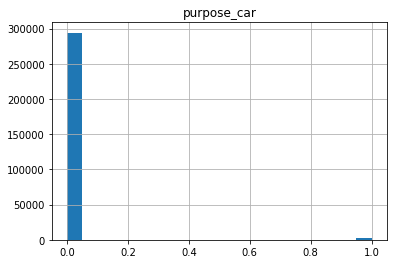

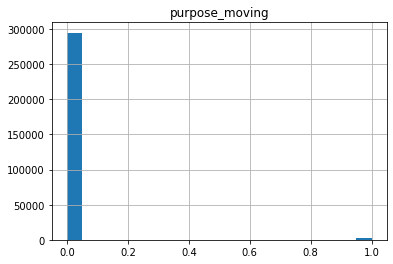

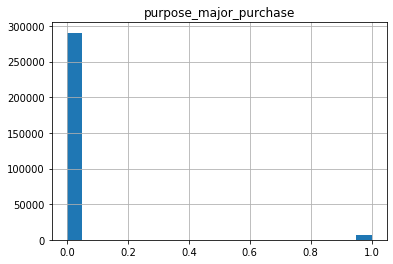

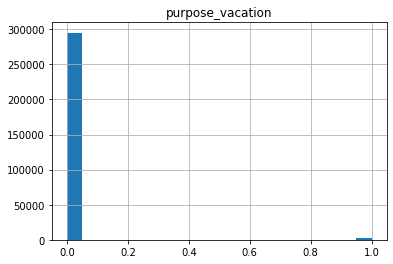

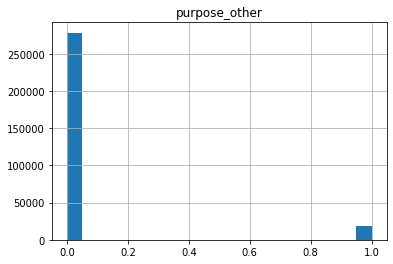

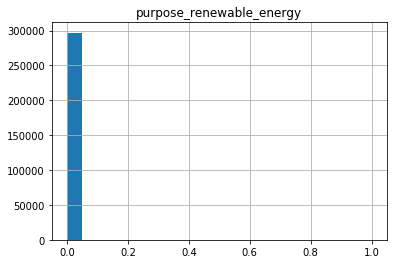

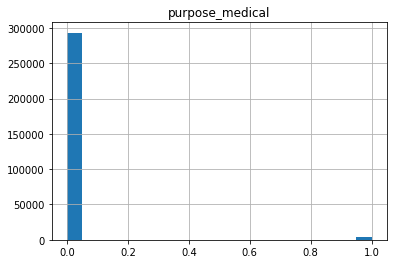

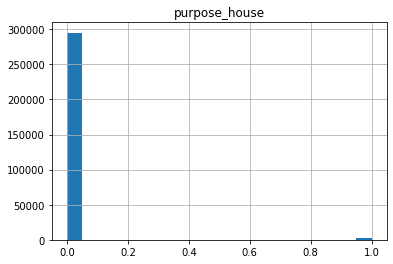

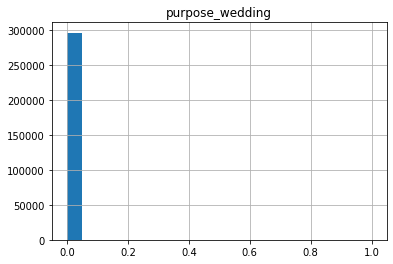

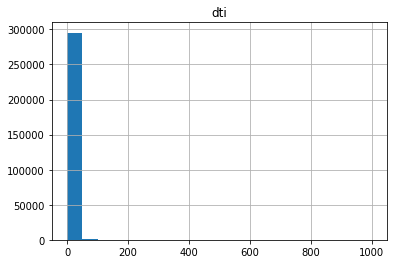

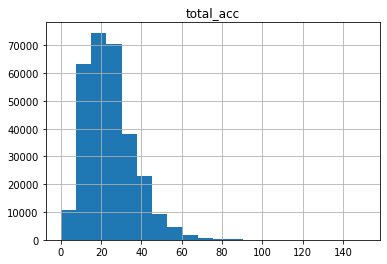

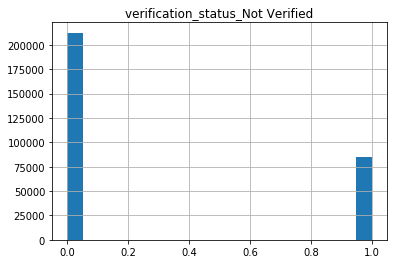

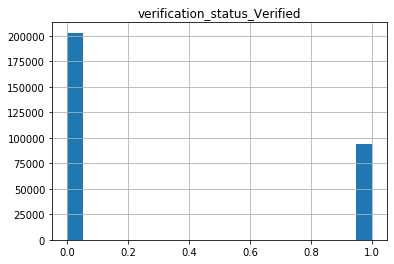

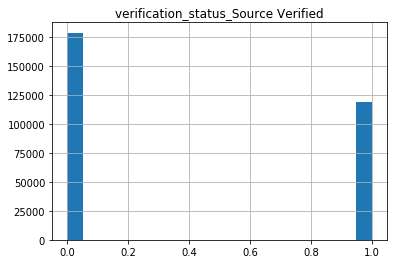

In [104]:
for col in columns_of_interest:
    data.loc[samples, col].hist(bins=20)
    plt.title(col)
    plt.show()

In [159]:
data = data[columns_of_interest]
data['term_long'] = (data['term'] - data['term'].min()) / (data['term'].max() - data['term'].min())
data.drop(columns=['term'], inplace=True)
for col in ['annual_inc', 'dti', 'total_acc']:
    data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)
    data.drop(columns=[col], inplace=True)

<ipython-input-159-e24722044615>:5: RuntimeWarning: divide by zero encountered in log
  data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)
<ipython-input-159-e24722044615>:5: RuntimeWarning: invalid value encountered in log
  data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)


In [184]:
data.loc[samples].to_pickle('x_in_sample.pkl_gzip')
data.loc[samples_out].to_pickle('x_out_sample.pkl_gzip')
y[samples].to_pickle('y_in_sample.pkl.gzip')
y[samples_out].to_pickle('y_out_sample.pkl.gzip')

## Training and prediction

In [135]:
current_cols = []
possible_cols = list(data.columns)

for i in range(len(data.columns)):
    aics = []
    old_pvalues = []
    added_pvalues = []
    
    print('')
    print('----------------------------------------')

    for col in possible_cols:
        try:
            clf = sm.Logit(
                y[samples], 
                data.loc[samples, current_cols + [col]]
            ).fit(full_output=False, disp=False)
            aics.append(clf.aic)
            old_pvalues.append(clf.pvalues[:-1])
            added_pvalues.append(clf.pvalues[-1])
        except:
            aics.append(np.inf)
            old_pvalues.append([])
            added_pvalues.append(1)
            
    
    lowest_aic = 1e10
    for pvalue, aic in zip(added_pvalues, aics):
        if pvalue < 0.05 and aic < lowest_aic:
            lowest_aic = aic
            
    if lowest_aic == 1e10:
        print(added_pvalues)
        break
        
    best_col = aics.index(lowest_aic)
    
    print(f'--Best col: {possible_cols[best_col]} p-value={added_pvalues[best_col]}, aic={aics[best_col]}--')

    current_cols.append(possible_cols.pop(best_col))
    
    print(f'---- Current columns ----')
    for i, pvalue in enumerate(old_pvalues[best_col]):
        print(f'{current_cols[i]}: pvalue={pvalue}')
        if pvalue > 0.2:
            print(f'--Remove col: {current_cols[i]}, p-value={pvalue}--')
            possible_cols.append(current_cols.pop(i))
    
print('DONE')
print(current_cols)


----------------------------------------
--Best col: grade p-value=0.0, aic=402039.0254605488--
---- Current columns ----

----------------------------------------
--Best col: annual_inc_log p-value=0.0, aic=378914.4553627108--
---- Current columns ----
grade: pvalue=0.0

----------------------------------------
--Best col: sub_grade p-value=0.0, aic=377435.00774803665--
---- Current columns ----
grade: pvalue=0.09150981694479794
annual_inc_log: pvalue=0.0

----------------------------------------
--Best col: int_rate p-value=0.0, aic=373938.0128840787--
---- Current columns ----
grade: pvalue=0.08017630398702558
annual_inc_log: pvalue=6.412606129031895e-25
sub_grade: pvalue=0.0

----------------------------------------
--Best col: home_ownership_RENT p-value=2.6292084839638434e-201, aic=373022.96805126924--
---- Current columns ----
grade: pvalue=0.018351478460603816
annual_inc_log: pvalue=4.736208713275362e-37
sub_grade: pvalue=0.0
int_rate: pvalue=0.0

-----------------------------

--Best col: loan_amnt p-value=3.0312038353404427e-14, aic=370523.1860829938--
---- Current columns ----
grade: pvalue=1.458850992865059e-05
annual_inc_log: pvalue=2.077821571826772e-65
sub_grade: pvalue=0.0
int_rate: pvalue=0.0
home_ownership_RENT: pvalue=9.58926744023779e-223
verification_status_Not Verified: pvalue=4.41050400872502e-09
total_acc_log: pvalue=8.037041160359973e-118
verification_status_Verified: pvalue=7.655962361159846e-21
verification_status_Source Verified: pvalue=4.053760314742331e-16
purpose_other: pvalue=5.987154058070542e-27
home_ownership_OWN: pvalue=2.4043648220583883e-23
emp_length: pvalue=2.218111085661724e-15
purpose_credit_card: pvalue=1.215377681837616e-14
purpose_house: pvalue=3.997818453771709e-11
dti_log: pvalue=1.8446593768287912e-09
purpose_small_business: pvalue=9.663764731822926e-09
installment: pvalue=2.1238834789778116e-18

----------------------------------------
--Best col: term_long p-value=1.7075250686188258e-31, aic=370388.6729950292--
---- C

In [138]:
best_params = ['grade', 'annual_inc_log', 'sub_grade', 'int_rate', 'home_ownership_RENT', 
               'verification_status_Not Verified', 'total_acc_log', 'verification_status_Verified', 
               'verification_status_Source Verified', 'purpose_other', 'home_ownership_OWN', 'emp_length', 
               'purpose_credit_card', 'purpose_house', 'dti_log', 'purpose_small_business', 'installment', 
               'loan_amnt', 'term_long', 'purpose_car', 'purpose_wedding']

In [139]:
clf = sm.Logit(y[samples], data.loc[samples, best_params]).fit()

Optimization terminated successfully.
         Current function value: 0.623387
         Iterations 5


In [167]:
y_hat_insample = clf.predict(data.loc[samples, best_params])

In [182]:
y_hat_outsample = clf.predict(data.loc[samples_out, best_params])

In [185]:
with open('y_hat_in_sample.pkl', 'wb') as f:
    pickle.dump(y_hat_insample, f)

In [186]:
with open('y_hat_out_sample.pkl', 'wb') as f:
    pickle.dump(y_hat_outsample, f)

In [191]:
(y_hat_insample.round() == y[samples]).sum() / len(samples)

0.652444854426459

In [192]:
(y_hat_outsample.round() == y[samples_out]).sum() / len(samples_out)

0.6503834577859774